# Implementation of a Multi-layer Perceptron in Numpy

**EE514: Data Analysis and Machine Learning**

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

This notebook illustrates how to implement modular backprop manually using Numpy. We will create some classes for each layer type and define operations to allow us to do forward propagation, back propagation, and gradient updates.

## Import packages and define some utility functions

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# import seaborn for nicer plots
import seaborn as sns
sns.set_style('white')

Our usual function for plotting decision boundaries.

In [ ]:
def plot_decision_function(df, X, y, levels=(0, 1)):
    
    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min
    
    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range
    
    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)
    
    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    
    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    # Plot the decision function
    figure(figsize=(7,7))
    contour(X0, X1, Y, levels=levels, 
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')
    
    # Plot the data
    scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')

Here we define some "safe" versions of $\log(x)$ and $\exp(x)$ that don't blow up as $x$ gets very large or very small. This helps with numerical stability. We also implement the sigmoid function, its derivative, cross entropy, and the derivative of cross entropy.

In [ ]:
# define some utility functions

def safe_log(x):
    # log blows up as x approaches zero
    x_clipped = np.clip(x, np.finfo(x.dtype).tiny, np.inf)
    return np.log(x_clipped)

def safe_exp(x):
    # exp blows up as x gets large
    x_clipped = np.clip(x, -np.inf, 100)
    return np.exp(x_clipped)

def sigmoid(x):
    return 1.0 / (1.0 + safe_exp(-x))

def grad_sigmoid(x):
    g = sigmoid(x)
    return g * (1.0 - g)

def cross_entropy(y, y_hat):
    return -y * safe_log(y_hat) - (1.0 - y) * safe_log(1.0 - y_hat)

def grad_cross_entropy(y, y_hat):
    numer = (y - y_hat)
    denom = y_hat * (y_hat - 1.0)
    return (numer + 1e-8) / (denom + 1e-8)

## Implement the Layer base class
This is the base class for all our layer modules. It serves as an interface and provides default "do nothing" versions of each method.

In [ ]:
class Layer(object):
    """Base class for layers"""
    
    def init(self):
        """Set any parameters to initial values"""
    
    def forward(self, inputs, target=None):
        """Compute layer output from layer input"""
        
    def backward(self, inputs, error=None):
        """Back propagate error to layer below"""
        
    def get_updates(self, X, error_above):
        """Get the gradient wrt parameters"""
        return None
    
    def update_parameters(self, updates, lr, weight_decay=0):
        """Update the weights"""

## Implement the different layers

Now we define each layer module. We will define three types of layers:

- A** dense layer**:  $Wx + b$. This is also called a linear layer or fully connected layer
- A **ReLU layer**:  $\max\{0, x\}$. Popular non-linearity used in deep learning
- A **sigmoid layer**: $1/(1+e^{-x})$. Squashes input to $[0,1]$.

We also define a "layer" for the loss (binary cross entropy). This layer is different from the others in that it produces the error for the network in the forward pass, and produces the initial error signal in the backward pass (gradient of loss wrt. the predictions).

In [ ]:
class Dense(Layer):
    """A dense or linear layer Wx + b"""
    
    def __init__(self, n_in, n_out):
        self.n_in, self.n_out = n_in, n_out
        self.init()
        
    def init(self):
        # Use small random values from a zero mean Gaussian to initialize
        self.W = np.random.randn(self.n_in, self.n_out)
        self.b = np.random.randn(self.n_out)
    
    def forward(self, X, target=None):
        return np.dot(X, self.W) + self.b
    
    def backward(self, X, error_above):
        return np.dot(error_above, self.W.T)
    
    def get_updates(self, X, error_above):
        dW = np.dot(X.T, error_above)
        db = error_above.mean(axis=0)
        return dW, db
        
    def update_parameters(self, updates, lr, weight_decay=0):
        dW, db = updates
        # gradient descent update
        self.W -= lr * dW - weight_decay * self.W
        self.b -= lr * db 
    
    
class ReLU(Layer):
    """A ReLU activation function"""
    
    def forward(self, X, target=None):
        return np.maximum(X, 0)
    
    def backward(self, X, error):
        return error.reshape(X.shape) * (X > 0)

    
class Sigmoid(Layer):
    """A sigmoid activation function"""
    
    def forward(self, X, target=None):
        return sigmoid(X)
    
    def backward(self, X, error):
        return error.reshape(X.shape) * grad_sigmoid(X)
        

class BinaryCrossEntropy(Layer):
    """Binary cross entropy loss"""
    
    def forward(self, y_hat, target):
        self.y = target.reshape(y_hat.shape)
        return cross_entropy(self.y, y_hat)
    
    def backward(self, y_hat, error=None):
        return grad_cross_entropy(self.y, y_hat).reshape(y_hat.shape)

## Implement initialization, prediction, and training functions

In this simple implementation, a network is simply a list of layers that ends with a loss layer. 

Let's define some functions for initializing the weights of the network, making predictions given inputs, and performing a training step on a batch.

In [ ]:
def init(network):
    """
    Initialize the weights of the network
    
    Parameters
    ----------
    network: list
        list of network layers
    """
    for layer in network:
        layer.init()
    return network
        

def predict(network, inputs):
    """
    Predict outputs from inputs
    
    Parameters
    ----------
    network: list
        list of network layers
    inputs: np.ndarray, shape=(N, D)
        design matrix
        
    Returns
    -------
    result: np.ndarray, shape=(N, P)
        network predictions
    """
    result = inputs
    for layer in network[:-1]:
        result = layer.forward(result)
    return result
                   
                   
def train_step(network, X, y, lr=0.01, wd=1e-4):
    """
    Run a gradient descent training step (full batch)
    
    Parameters
    ----------
    network: list
        list of network layers
    X: np.ndarray, shape=(N, D)
        design matrix
    y: np.ndarray, shape=(N,)
        target
    lr: float
        learning rate
    wd: float
        weight decay regularization coefficient
        
    Returns
    -------
    loss: float
        value of the loss
    """
    
    # forward pass
    outputs = [X]
    for layer in network:
        layer_input = outputs[-1]
        layer_output = layer.forward(layer_input, y)
        outputs.append(layer_output)
        
    loss = outputs[-1].mean()
    
    # backward pass
    error = 1
    for layer, X in reversed(list(zip(network, outputs[:-1]))):
        # compute parameter updates (dL/dW)
        updates = layer.get_updates(X, error)
        # backprop error to layer below
        error = layer.backward(X, error)
        # apply updates (gradient descent)
        layer.update_parameters(updates, lr, wd)
        
    return loss  

## Specify a neural network architecture.

Here we define a simple classification network that takes inputs in $\mathbb{R}^2$ to targets in $[0, 1]$. The network has three dense layers 4, 4, and 1 neurons. The first two dense layers are followed by a ReLU and the final dense layer is followed by a sigmoid. 

In [ ]:
# Create a simple classification network
network = [
    Dense(2, 4),
    ReLU(),
    Dense(4, 4),
    ReLU(),
    Dense(4, 1),
    Sigmoid(),
    BinaryCrossEntropy()
]

## Generate a dataset

Generate a simple 2D classification dataset using scikit-learn's `make_blobs`

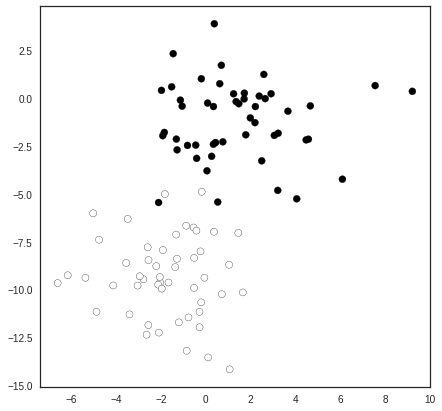

In [ ]:
# Generate some random data
from sklearn.datasets import make_blobs, make_circles
X, y = make_blobs(centers=2, cluster_std=2, random_state=2)

figure(figsize=(7,7))
scatter(X[:,0], X[:,1], c=y, edgecolors='k')
show()

Let's look at the initial (random) decision boundary before any training

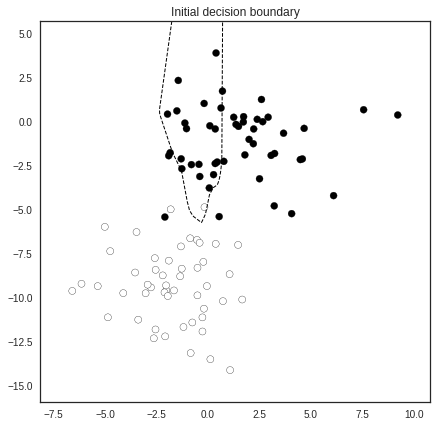

In [ ]:
# initialize the network and plot the initial (random) decision boundary
np.random.seed(11)
init(network)
df = lambda X: predict(network, X)
plot_decision_function(df, X, y, levels=(0.5,))
title('Initial decision boundary')
show()

## Train the network

Now lets train the network and plot the new decision boundary after training

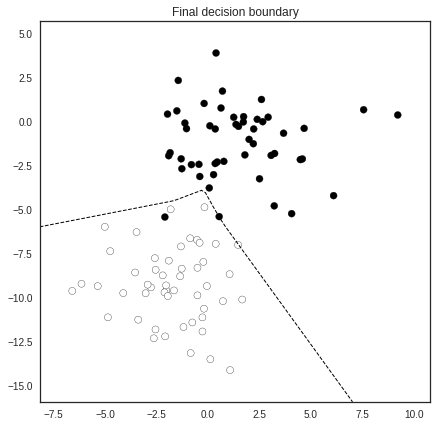

In [ ]:
# train the network for 500 epochs
lr = 0.001
epochs = 500

losses = []
for i in range(epochs):
    losses.append(train_step(network, X, y, lr, wd=1e-6))
    
plot_decision_function(df, X, y, levels=(0.5,))
title('Final decision boundary')
show()

## Plot the loss

We can plot the training loss over time to see if it reduces

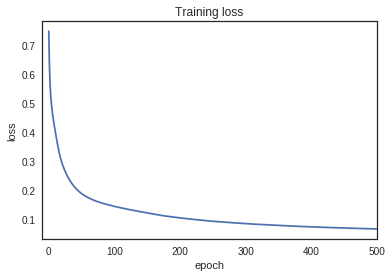

In [ ]:
plot(losses)
xlim(-10, len(losses))
xlabel('epoch')
ylabel('loss')
title('Training loss')
show()

## Exercises

- Make the learning rate 0.1 and re-run the initialization and training cells and plot the loss. What happens?
- Make the learning rate 0.00001 and try the same thing (remember to re-initialize!). What happens?
- Modify the training loop to plot the decision function after each epoch for the first 20 epochs so that you can see it evolve.
- Try swapping out the ReLU non-linearities for Sigmoid layers and re-run the notebook. Does this affect how quickly the network learns and the shape of the decision boundaries?
